In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

# Load SNP data from CSV file (already transposed, GIDs as row names, SNPs as columns)
def load_snp_csv(snp_file):
        df = pd.read_csv(snp_file, index_col=0)  # GIDs are row indices
        df = df.astype(float)  # Ensure numerical values
        return df

# Load height data from CSV file
def load_yield_data(yield_file):
        yield_df = pd.read_csv(yield_file)
        return yield_df.set_index("GID_filtered")  # Ensure genetic ID is the index
    
print("done 1")

done 1


In [2]:
# Load the data

X = load_snp_csv("SNPs_phased_reduced.csv")

print("done 2")

done 2


In [3]:
Y = load_yield_data("yield_data_reduced1.csv")
print("done 2.5")

done 2.5


In [4]:
# Ensure that we only use samples that have height data
matching_samples = list(set(X.index) & set(Y.index))

# Filter SNP and height data for matching samples
X = X.loc[matching_samples]  # GIDs are already rows
Y = Y.loc[matching_samples, "Y"].values.flatten()

print("done 3")


done 3


In [5]:
len(Y)

18085

In [6]:
# Split and normalise data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("done 4")


done 4


In [8]:

# Build the neural network model
#model = keras.Sequential([
#    layers.Input(shape=(X_train.shape[1],)),
#    layers.Dense(128, activation='relu'),
#    layers.Dropout(0.3),
#    layers.Dense(64, activation='relu'),
#    layers.Dense(1)
#])

model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(256, activation='relu'),  
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
362/362 [==============================] - 20s 52ms/step - loss: 2.8317 - mae: 1.1735 - root_mean_squared_error: 1.6828 - val_loss: 0.5674 - val_mae: 0.5904 - val_root_mean_squared_error: 0.7533
Epoch 2/100
362/362 [==============================] - 18s 49ms/step - loss: 0.8689 - mae: 0.7379 - root_mean_squared_error: 0.9321 - val_loss: 0.4822 - val_mae: 0.5478 - val_root_mean_squared_error: 0.6944
Epoch 3/100
362/362 [==============================] - 18s 49ms/step - loss: 0.7466 - mae: 0.6840 - root_mean_squared_error: 0.8640 - val_loss: 0.3894 - val_mae: 0.4886 - val_root_mean_squared_error: 0.6240
Epoch 4/100
362/362 [==============================] - 18s 49ms/step - loss: 0.6723 - mae: 0.6473 - root_mean_squared_error: 0.8199 - val_loss: 0.5494 - val_mae: 0.6001 - val_root_mean_squared_error: 0.7412
Epoch 5/100
362/362 [==============================] - 17s 48ms/step - loss: 0.6196 - mae: 0.6224 - root_mean_squared_error: 0.7871 - val_loss: 0.4076 - val_mae: 0.4980 - v

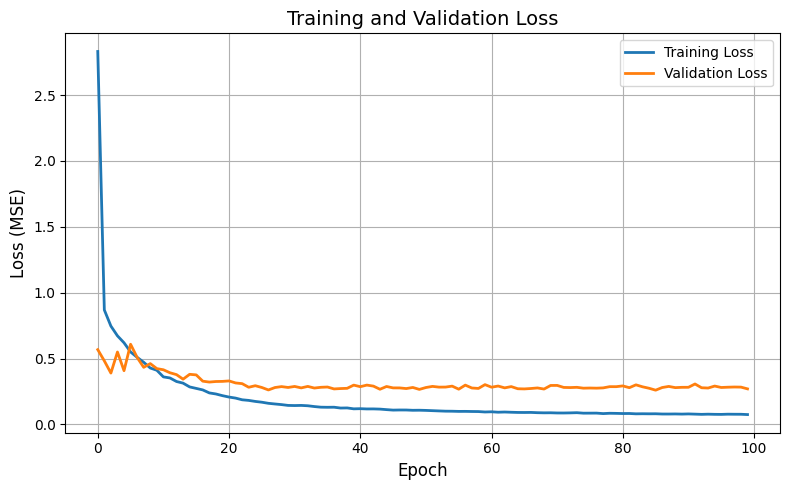

In [9]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result from model.fit()
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print(X_test_scaled.shape)

(3617, 84322)


In [12]:
import shap
import numpy as np

# Choose a background sample — e.g. 10000 random training points
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 10000, replace=False)]

# Select some test samples for SHAP explanation
test_samples = X_test_scaled[:1000]  # Pick 10 for fast demo

ValueError: Cannot take a larger sample than population when 'replace=False'

In [15]:
import shap
import numpy as np

# Choose a background sample
background = X_train_scaled

# Select some test samples for SHAP explanation
test_samples = X_test_scaled  # Pick 10 for fast demo

In [16]:
explainer = shap.DeepExplainer(model, background)

shap_values = explainer.shap_values(test_samples)

#shap_values = shap_values[0]  # shape: (10, num_features)


/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:153: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn(
/usr/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


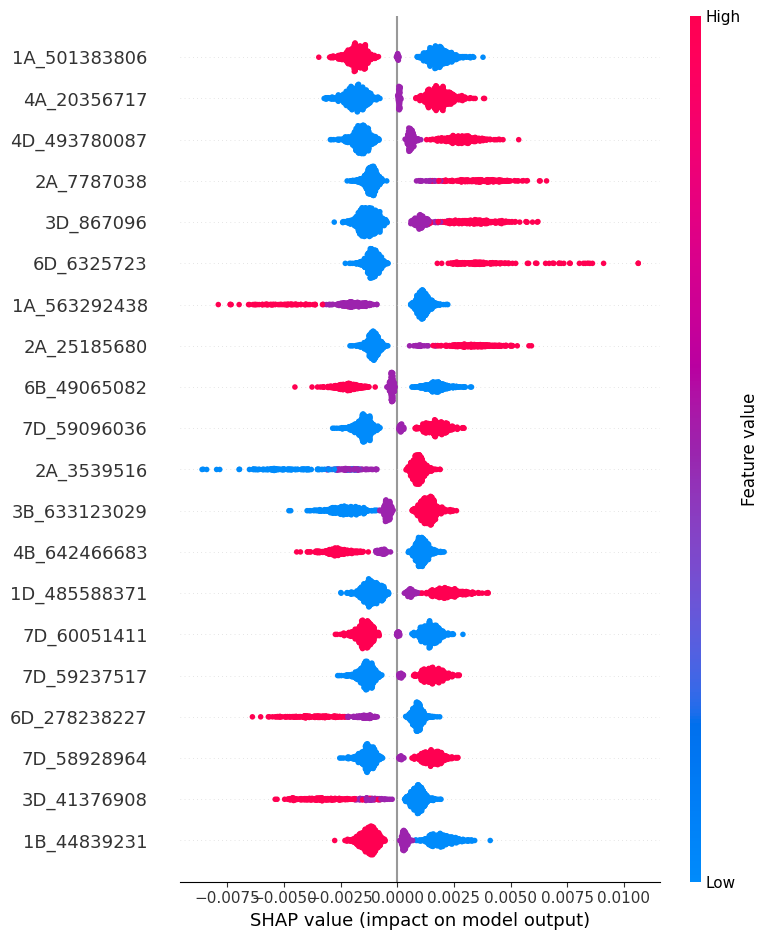

In [77]:
#10000 train and 1000 test samples

shap_values_squeezed = np.squeeze(shap_values)
shap.summary_plot(shap_values_squeezed, test_samples, feature_names=X.columns.tolist())

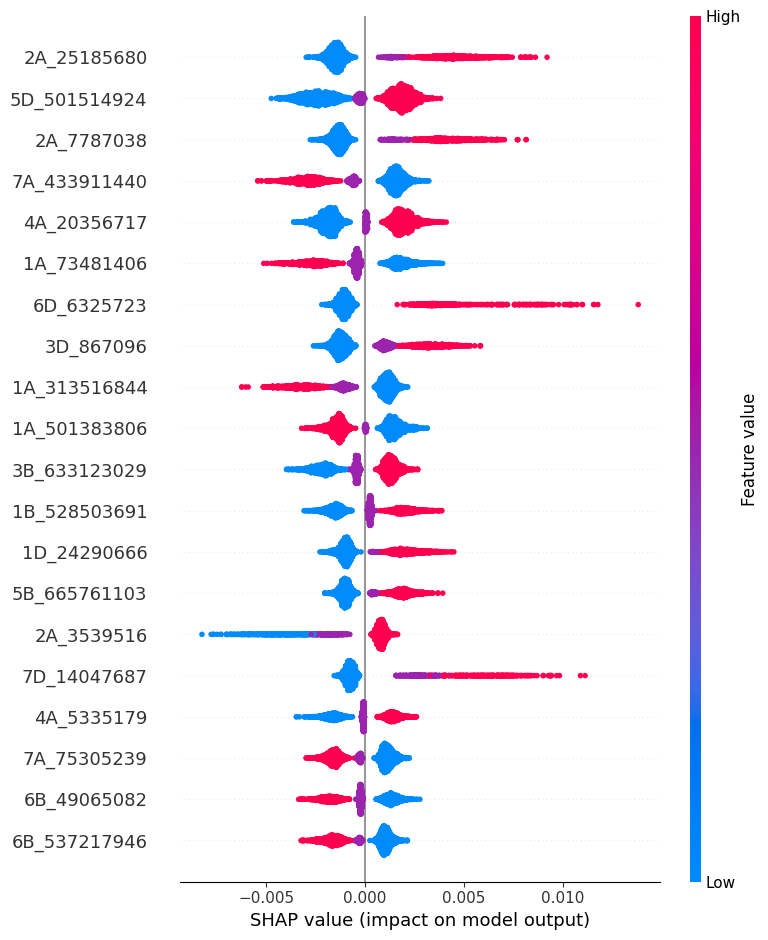

In [17]:
#All train and test samples

shap_values_squeezed = np.squeeze(shap_values)
shap.summary_plot(shap_values_squeezed, test_samples, feature_names=X.columns.tolist())

In [70]:
# Evaluate the model
test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, Y_test)
print(f"Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test_scaled)

# Save the model
model.save('wheat_height_predictor.h5')

114/114 [==============================] - 1s 7ms/step - loss: 0.2977 - mae: 0.4079 - root_mean_squared_error: 0.5457
Test MAE: 0.4078603982925415
114/114 [==============================] - 1s 8ms/step


In [71]:
np.corrcoef(Y_test, predictions.T)

array([[1.        , 0.65098238],
       [0.65098238, 1.        ]])

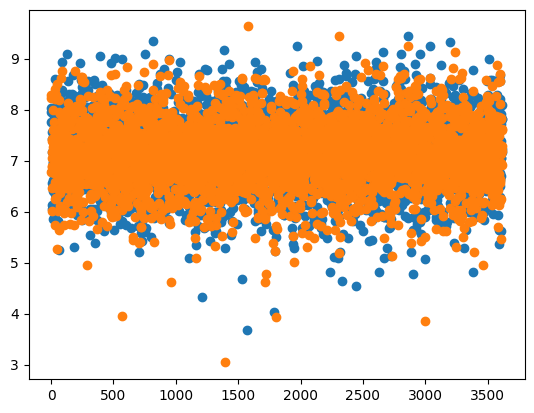

In [72]:
import matplotlib.pyplot as plt
plt.plot(Y_test, 'o')
plt.plot(predictions, 'o')
#Y_test.shape